In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import tifffile

import sys
sys.path.append("../")
import maskflow

root_dir = Path("/home/hadim/.data/Neural_Network/Maskflow/Shapes")
saved_model_dir = root_dir / "SavedModel"

model_name = "microtubule-v0.2.zip"
model_name = "small_training.zip"

model_location = saved_model_dir / model_name

Using TensorFlow backend.


# Load an image

(256, 256, 3)

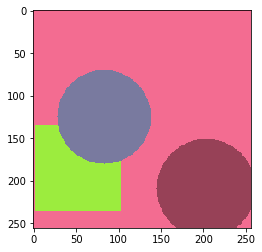

In [2]:
data_dir = root_dir / "Data"
#data_dir = Path("/home/hadim/Documents/Code/Postdoc/ij/testdata/")

image_path = data_dir / "fake-flat-corrected.tif"
image_path = data_dir / "7,5uM_emccd_lapse1-small-8bit-Single.tif"
#image_path = data_dir / "test-tracking-single.tif"
#image_path = data_dir / "test-tracking.tif"

image_path = data_dir / "Image" / "toy_0009.tif"

original_images = tifffile.imread(str(image_path))
#original_images = original_images[:, :, 0]

if len(original_images.shape) == 2 or original_images.shape[-1] == 3:
    original_images = np.expand_dims(original_images, 0)

original_image = original_images[0]
plt.imshow(original_image)
original_image.shape

# Predict

In [3]:
config, results = maskflow.inference(original_image, model_location)
results["masks"].shape

(3, 256, 256)

# Display result of detection

circle
circle
square


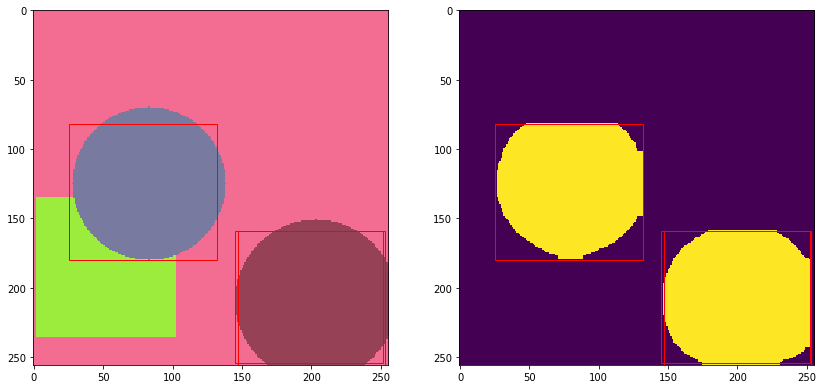

In [4]:
from matplotlib.patches import Rectangle

projected_masks = results['masks'].max(axis=0)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))

ax1.imshow(original_image)
ax2.imshow(projected_masks)

for i, roi in enumerate(results["rois"]):
    y1, x1, y2, x2 = roi
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red")
    ax1.add_artist(rect)
    rect = Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color="red")
    ax2.add_artist(rect)
    
    class_index = results["class_ids"][i]
    class_name = config["CLASS_NAMES"][class_index]
    print(class_name)